## **Expresso Churn Prediction**
Here, I worked on the 'Expresso churn' dataset that was provided as part of the Expresso Churn Prediction Challenge hosted by Zindi platform.

Expresso is an African telecommunications service company that provides telecommunication services in two African markets: Mauritania and Senegal. 
The data describes 2.5 million Expresso clients with more than 15 variables in order to predict the clients' churn probability.

In [16]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [18]:
%matplotlib inline

In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [2]:
# Loading dataset
df = pd.read_csv("Expresso_churn_dataset.csv")

In [3]:
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


In [4]:
df.shape

(2154048, 19)

In [5]:
df.columns.tolist()

['user_id',
 'REGION',
 'TENURE',
 'MONTANT',
 'FREQUENCE_RECH',
 'REVENUE',
 'ARPU_SEGMENT',
 'FREQUENCE',
 'DATA_VOLUME',
 'ON_NET',
 'ORANGE',
 'TIGO',
 'ZONE1',
 'ZONE2',
 'MRG',
 'REGULARITY',
 'TOP_PACK',
 'FREQ_TOP_PACK',
 'CHURN']

In [6]:
df.dtypes

user_id            object
REGION             object
TENURE             object
MONTANT           float64
FREQUENCE_RECH    float64
REVENUE           float64
ARPU_SEGMENT      float64
FREQUENCE         float64
DATA_VOLUME       float64
ON_NET            float64
ORANGE            float64
TIGO              float64
ZONE1             float64
ZONE2             float64
MRG                object
REGULARITY          int64
TOP_PACK           object
FREQ_TOP_PACK     float64
CHURN               int64
dtype: object

In [7]:
df.isnull().sum()

user_id                 0
REGION             849299
TENURE                  0
MONTANT            756739
FREQUENCE_RECH     756739
REVENUE            726048
ARPU_SEGMENT       726048
FREQUENCE          726048
DATA_VOLUME       1060433
ON_NET             786675
ORANGE             895248
TIGO              1290016
ZONE1             1984327
ZONE2             2017224
MRG                     0
REGULARITY              0
TOP_PACK           902594
FREQ_TOP_PACK      902594
CHURN                   0
dtype: int64

In [8]:
# Sample 50000 random rows from the DataFrame
df_sampled = df.sample(n=100000, random_state=42)

In [9]:
df_sampled.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
566939,4361fb4fad11445ce7ec1ee054f41de5deba6fef,DAKAR,K > 24 month,4200.0,8.0,4199.0,1400.0,14.0,1.0,314.0,132.0,NaN,NaN,NaN,NO,20,On net 200F=Unlimited _call24H,3.0,0
620796,49c7c0d15acb8c92f9f4d8d3342385e996a9d292,SAINT-LOUIS,K > 24 month,1000.0,2.0,1000.0,333.0,2.0,NaN,59.0,3.0,NaN,NaN,NaN,NO,17,"On-net 500=4000,10d",1.0,0
299703,23b4832c1ebee58bfdd2cc0c3886523d93f03c97,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN,1
1051494,7d0e2093cc4ca7fa9c50d68b539922a26a85306e,KOLDA,K > 24 month,5300.0,15.0,5150.0,1717.0,18.0,NaN,1482.0,88.0,NaN,NaN,NaN,NO,50,On net 200F=Unlimited _call24H,7.0,0
527353,3eac0fdfcf454d2857f26b6d41479033b7bb7366,TAMBACOUNDA,K > 24 month,200.0,1.0,399.0,133.0,3.0,32.0,7.0,0.0,NaN,NaN,NaN,NO,39,"Data: 100 F=40MB,24H",1.0,0


In [10]:
df_sampled.shape

(100000, 19)

In [11]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 566939 to 1986480
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         100000 non-null  object 
 1   REGION          60612 non-null   object 
 2   TENURE          100000 non-null  object 
 3   MONTANT         64964 non-null   float64
 4   FREQUENCE_RECH  64964 non-null   float64
 5   REVENUE         66312 non-null   float64
 6   ARPU_SEGMENT    66312 non-null   float64
 7   FREQUENCE       66312 non-null   float64
 8   DATA_VOLUME     50787 non-null   float64
 9   ON_NET          63598 non-null   float64
 10  ORANGE          58534 non-null   float64
 11  TIGO            40316 non-null   float64
 12  ZONE1           7808 non-null    float64
 13  ZONE2           6291 non-null    float64
 14  MRG             100000 non-null  object 
 15  REGULARITY      100000 non-null  int64  
 16  TOP_PACK        58188 non-null   object 
 17  FREQ_TOP_

In [12]:
df_sampled.describe()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
count,64964.000000,64964.000000,66312.000000,66312.000000,66312.000000,50787.000000,63598.000000,58534.000000,40316.000000,7808.000000,6291.000000,100000.000000,58188.000000,100000.00000
mean,5472.237762,11.464242,5458.459012,1819.491480,13.933195,3289.870715,275.285937,95.981686,22.627766,7.563397,7.587188,28.050760,9.216694,0.18702
std,6889.369333,13.179574,6932.955646,2310.982859,14.611342,11891.046316,858.222288,206.357819,58.328777,32.718917,35.586052,22.280221,12.019911,0.38993
min,20.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000
25%,1000.000000,2.000000,1000.000000,333.000000,3.000000,0.000000,5.000000,7.000000,2.000000,0.000000,0.000000,6.000000,2.000000,0.00000
50%,3000.000000,6.000000,3000.000000,1000.000000,9.000000,253.000000,27.000000,29.000000,6.000000,1.000000,1.000000,24.000000,5.000000,0.00000
75%,7250.000000,15.000000,7299.000000,2433.000000,19.000000,2911.000000,158.000000,99.000000,20.000000,3.000000,5.000000,51.000000,12.000000,0.00000
max,189300.000000,114.000000,165166.000000,55055.000000,91.000000,737388.000000,36687.000000,4743.000000,1739.000000,1274.000000,1346.000000,62.000000,320.000000,1.00000


In [13]:
df_sampled.isnull().sum()

user_id               0
REGION            39388
TENURE                0
MONTANT           35036
FREQUENCE_RECH    35036
REVENUE           33688
ARPU_SEGMENT      33688
FREQUENCE         33688
DATA_VOLUME       49213
ON_NET            36402
ORANGE            41466
TIGO              59684
ZONE1             92192
ZONE2             93709
MRG                   0
REGULARITY            0
TOP_PACK          41812
FREQ_TOP_PACK     41812
CHURN                 0
dtype: int64

In [14]:
# Generating profiling report 
profile = ProfileReport(df_sampled, title="Expresso Churn Data Report", explorative=True)
profile.to_file("expresso_churn_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:03<00:00,  5.10it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Handling missing values (simple strategy: fill numeric with median, categorical with mode)
for col in df_sampled.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df_sampled.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [19]:
df_sampled.duplicated().sum()

0

In [20]:
# Handling outliers using IQR method for numerical features
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    df = remove_outliers(df, col)

In [21]:
# Selecting only numeric columns for correlation
numeric_df = df_sampled.select_dtypes(include=[float, int])
correlation_matrix = numeric_df.corr()

correlation_matrix

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
MONTANT,1.000000,0.805821,0.978256,0.978256,0.788165,0.308800,0.328707,0.663848,0.429299,0.306392,0.444449,0.531121,0.763268,-0.106161
FREQUENCE_RECH,0.805821,1.000000,0.817594,0.817593,0.955619,0.167199,0.405682,0.522492,0.354180,0.111234,0.114891,0.558644,0.878956,-0.123226
REVENUE,0.978256,0.817594,1.000000,1.000000,0.802397,0.315963,0.335719,0.668898,0.433249,0.313911,0.338691,0.543237,0.773949,-0.117211
ARPU_SEGMENT,0.978256,0.817593,1.000000,1.000000,0.802396,0.315964,0.335720,0.668898,0.433249,0.313911,0.338690,0.543235,0.773948,-0.117212
FREQUENCE,0.788165,0.955619,0.802397,0.802396,1.000000,0.192312,0.393752,0.473352,0.316073,0.102911,0.148542,0.591372,0.852332,-0.140423
DATA_VOLUME,0.308800,0.167199,0.315963,0.315964,0.192312,1.000000,-0.019552,0.062076,0.018821,0.010882,0.041832,0.197233,0.133995,-0.032314
ON_NET,0.328707,0.405682,0.335719,0.335720,0.393752,-0.019552,1.000000,0.228520,0.142134,0.022608,-0.000365,0.271720,0.359337,-0.057855
ORANGE,0.663848,0.522492,0.668898,0.668898,0.473352,0.062076,0.228520,1.000000,0.426251,0.077190,0.021272,0.310675,0.565801,-0.064096
TIGO,0.429299,0.354180,0.433249,0.433249,0.316073,0.018821,0.142134,0.426251,1.000000,0.020016,0.018595,0.200343,0.377289,-0.028843
ZONE1,0.306392,0.111234,0.313911,0.313911,0.102911,0.010882,0.022608,0.077190,0.020016,1.000000,0.044051,0.056871,0.146129,-0.000107


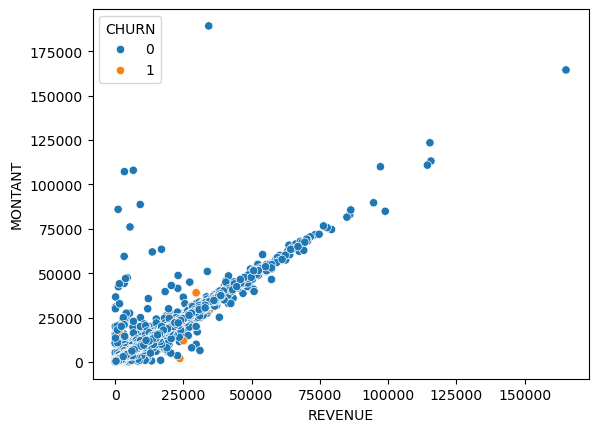

In [23]:
# Plotting features against CHURN and identify data points that are far away from the bulk of the data.
sns.scatterplot(x='REVENUE', y='MONTANT', data=df_sampled, hue='CHURN')
plt.show()

In [24]:
# Mean encoding for TENURE based on REVENUE
mean_encoded = df_sampled.groupby('TENURE')['REVENUE'].mean()
df_sampled['TENURE_encoded'] = df_sampled['TENURE'].map(mean_encoded)

In [27]:
# Encoding categorical features
label_encoders = {}
cat_cols = df_sampled.select_dtypes(include='object').columns.drop(['user_id'])

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

### **Modelling**

In [32]:
# Selecting  features and splitting the data into training and test sets.

X = X = df_sampled.drop(columns=[ "CHURN", "REGION", "TOP_PACK", "MRG", "user_id", "TENURE"])
y = df_sampled['CHURN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# Creating a StandardScaler instance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Random Forest Classifier**

In [34]:
# Using Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [35]:
print("Classification_report:\n", report)
print("\nConfusion_matrix:\n", conf_matrix)

Classification_report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89     16288
           1       0.54      0.75      0.63      3712

    accuracy                           0.83     20000
   macro avg       0.74      0.80      0.76     20000
weighted avg       0.86      0.83      0.84     20000


Confusion_matrix:
 [[13864  2424]
 [  920  2792]]


In [36]:
from sklearn.metrics import classification_report, roc_auc_score

print("ROC AUC Score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC Score: 0.8152419964348621


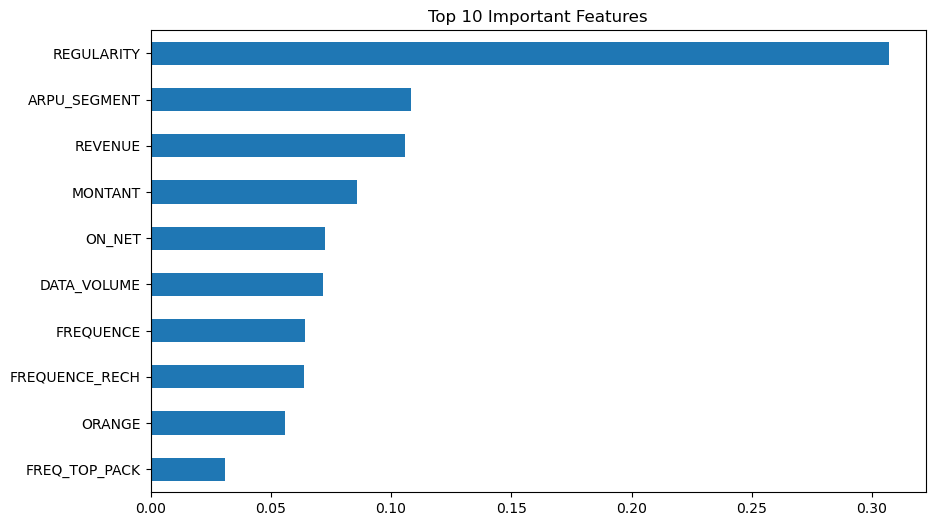

In [37]:
#Checking feature importance to see what is driving churn

importances = clf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.head(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()

**Light Gradient Boosting(LGBM)**

In [40]:
X = df_sampled[['FREQUENCE_RECH', 'REVENUE', 'ON_NET', 'DATA_VOLUME', 'MONTANT', 'ARPU_SEGMENT', 'REGULARITY', 'ORANGE', 'FREQ_TOP_PACK']]
y = df_sampled['CHURN']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
lgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, early_stopping_rounds=10, verbose=1)
# Fit the model
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Number of positive: 14990, number of negative: 65010
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 9
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187375 -> initscore=-1.467158
[LightGBM] [Info] Start training from score -1.467158
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.293876


LGBMClassifier(early_stopping_rounds=10, max_depth=6, verbose=1)

In [46]:
# Making predictions
y_pred = lgbm_model.predict_proba(X_test)[:, 1]  # To get probabilities for the positive class
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]

In [47]:
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, lgbm_model.predict_proba(X_test)[:, 1]))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     16288
           1       0.67      0.55      0.60      3712

    accuracy                           0.87     20000
   macro avg       0.78      0.74      0.76     20000
weighted avg       0.86      0.87      0.86     20000

Confusion Matrix:
[[15271  1017]
 [ 1668  2044]]

ROC AUC Score:
0.9015887185298253


In [48]:
# Save the model
joblib.dump(lgbm_model, "expresso_churn_model.pkl")

['expresso_churn_model.pkl']